local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /data/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.
Time for epoch 1 is 20.97473382949829 sec - gen_loss = 9.87628173828125, disc_loss = 3.2224767208099365
Time for epoch 2 is 12.567159414291382 sec - gen_loss = 13.164983749389648, disc_loss = 2.9418723583221436


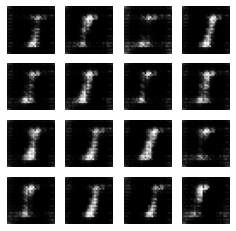

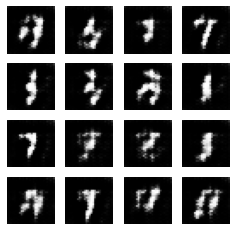

In [1]:
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow_datasets as tfds


class Generator(tf.keras.Model):
    #     ????
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = tf.keras.layers.Dense(7*7*64, use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.conv1 = tf.keras.layers.Conv2DTranspose(64, (5,5), strides=(1,1), padding='same', use_bias=False)
        self.bn2 = tf.keras.layers.BatchNormalization()
        
        self.conv2 = tf.keras.layers.Conv2DTranspose(32, (5,5), strides=(2,2), padding='same', use_bias=False)
        self.bn3 = tf.keras.layers.BatchNormalization()
        
        self.conv3 = tf.keras.layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False)
        
    def call(self, x, training=True):
        x = self.fc1(x)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        
        x = tf.reshape(x, shape=(-1, 7, 7, 64))
        
        x = self.conv1(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        
        x = self.conv2(x)
        x = self.bn3(x, training=training)
        x = tf.nn.relu(x)
        
        x = tf.nn.tanh(self.conv3(x))
        return x
        
        
class Discriminator(tf.keras.Model):
    #     ????
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (5,5), strides=(2,2), padding='same')
        self.conv2 = tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding='same')
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(1)
        
    def call(self, x, training=True):
        x = tf.nn.leaky_relu(self.conv1(x))
        x = self.dropout(x, training=training)
        
        x = tf.nn.leaky_relu(self.conv2(x))
        x = self.dropout(x, training=training)
        x = self.flatten(x)
        x = self.fc1(x)
        
        return x
    

def discriminator_loss(loss_object, real_output, fake_output):
    #here = tf.ones_like(????) or tf.zeros_like(????)  -> tf.zeros_like와 tf.ones_like에서 선택하고 (???)채워주세요
#     real_loss = loss_object(here(????), ????)
#     fake_loss = loss_object(here(????), ???)
# 진짜 이미지에 대한 감별자의 예측과 1로 이루어진 행렬을 비교하고, 가짜 (생성된) 이미지에 대한 감별자의 예측과 0으로 이루어진 행렬을 비교합니다.
    real_loss = loss_object(tf.ones_like(real_output), real_output)
    fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(loss_object, fake_output):
#     return ?????
# 감별자는 가짜 이미지를 진짜 (또는 1)로 분류를 할 것입니다. 여기서 우리는 생성된 이미지에 대한 감별자의 결정을 1로 이루어진 행렬과 비교를 할 것입니다.
    return loss_object(tf.ones_like(fake_output), fake_output)

def normalize(x):
    image = tf.cast(x['image'], tf.float32)
    image = (image / 127.5) - 1
    return image


def save_imgs(epoch, generator, noise):
    gen_imgs = generator(noise, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(gen_imgs.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(gen_imgs[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    fig.savefig("images/mnist_%d.png" % epoch)

def train():
    data, info = tfds.load("mnist", with_info=True, data_dir='/data/tensorflow_datasets')
    train_data = data['train']

    if not os.path.exists('./images'):
        os.makedirs('./images')

    # settting hyperparameter
#     latent_dim = ???
    latent_dim = 100 # The latent space itself has no meaning. Typically it is a 100-dimensional hypersphere with each variable drawn from a Gaussian distribution with a mean of zero and a standard deviation of one.
    epochs = 2
    batch_size = 100
    buffer_size = 600
    save_interval = 1

    generator = Generator()
    discriminator = Discriminator()

#     gen_optimizer = tf.keras.optimizers.Adam(?,beta_1 = ?, beta_2 = ?)
#     disc_optimizer = tf.keras.optimizers.Adam(?,beta_1 = ?, beta_2 = ?)
    gen_optimizer = tf.keras.optimizers.Adam(1e-4,beta_1 = 0.9, beta_2 = 0.999) # 이동평균의 지수함수적인 감쇠율, beta_1: 경사의 1차 모멘트(평균)과 관련 beta_2: 경사의 2차 모멘트(분산)과 관련
    disc_optimizer = tf.keras.optimizers.Adam(1e-4,beta_1 = 0.9, beta_2 = 0.999)

    train_dataset = train_data.map(normalize).shuffle(buffer_size).batch(batch_size)

#     cross_entropy = ?????
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    @tf.function
    def train_step(images):
        noise = tf.random.normal([batch_size, latent_dim])

        with tf.GradientTape(persistent=True) as tape:
#             generated_images = generator(???)
            generated_images = generator(noise)

#             real_output = discriminator(???)
#             generated_output = discriminator(????)
            real_output = discriminator(images)
            generated_output = discriminator(generated_images)

#             gen_loss = generator_loss(????, ????)
#             disc_loss = discriminator_loss(????, ?????, ????)
            gen_loss = generator_loss(cross_entropy, generated_output)
            disc_loss = discriminator_loss(cross_entropy, real_output, generated_output)

        grad_gen = tape.gradient(gen_loss, generator.trainable_variables)
        grad_disc = tape.gradient(disc_loss, discriminator.trainable_variables)

        gen_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))
        disc_optimizer.apply_gradients(zip(grad_disc, discriminator.trainable_variables))

        return gen_loss, disc_loss

    seed = tf.random.normal([16, latent_dim])

    for epoch in range(epochs):
        start = time.time()
        total_gen_loss = 0
        total_disc_loss = 0

        for images in train_dataset:
            gen_loss, disc_loss = train_step(images)

            total_gen_loss += gen_loss
            total_disc_loss += disc_loss

        print('Time for epoch {} is {} sec - gen_loss = {}, disc_loss = {}'.format(epoch + 1, time.time() - start, total_gen_loss / batch_size, total_disc_loss / batch_size))
        if epoch % save_interval == 0:
            save_imgs(epoch, generator, seed)


if __name__ == "__main__":
    train()